# Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## Data

We will use Caltech 101 dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images.

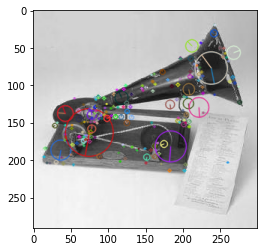

In [125]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = 'content/101_ObjectCategories'
img = cv.imread(img_dir + '/gramophone/image_0014.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
kp,des = sift.compute(gray,kp)

## Task 1. Index keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, we will index descriptors of all images using some datastructure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a query image we generate its descriptors, and for each of them find its k nearest neighbors (using Euclidean or Cosine distance). Finally, we sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in k nearest neighbors.



Read all images, saving category information. For every image generate SIFT descriptors and index them using some datastructure for inexact nearest neighbors search, e.g., I am using HNSW from [`nmslib`](https://github.com/nmslib/nmslib).

In [0]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xvf  '/content/101_ObjectCategories.tar.gz'

In [0]:
import os
import numpy as np
import numpy as geek 
top_k = 25
pictures_l = np.zeros((1,128), dtype=int)
pictures_i = []
root = "/content/101_ObjectCategories"
for subdir, dirs, files in os.walk(root):
    print (subdir)
    for file in files:
      ima = os.path.join(subdir, file)
      print(ima)
      img = cv.imread(ima)
      gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
      sift = cv.xfeatures2d.SIFT_create()
      kp = sift.detect(gray,None)
      if kp!=[]:
        kp = sorted([(kpt, kpt.response) for kpt in kp], key=lambda tup: tup[1], reverse=True)
        kp = [tup[0] for tup in kp[:top_k]]
        kp,des = sift.compute(gray,kp)
        pictures_l = np.vstack((pictures_l,des)) 
        jump = des.shape[0]
        pictures_i.extend([ima for i in range(jump)])
        # pictures_l.append(des)
        # pictures_i.append(ima)
pictures_l = np.delete(pictures_l, 0, axis=0)
# pictures.pop('/content/101_ObjectCategories',None)

In [314]:
!pip install nmslib
import nmslib
import numpy
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(pictures_l)
index.createIndex({'post': 2}, print_progress=True)

# query for the nearest neighbours of the first datapoint
ids, distances = index.knnQuery(pictures_l[0], k=10)

# get all nearest neighbours for all the datapoint
# using a pool of 4 threads to compute
neighbours = index.knnQueryBatch(pictures_l, k=10, num_threads=4)

## Task 2. Find similar and evaluate

Now, having index calculated, let's pick **one image from each category** (**the first one**, for sync), and find its **10** most similar images among all images. When submitting, please **only include the output of similar images for the "accordion" category**, as demonstrated below, so that the notebook doesn't grow too big.

If a similar image belongs to the same category, we consider it as a hit. At last, compute and print the accuracy - the number of hits over total possible number of hits.

In [0]:
ima = os.path.join(subdir, file)
img = cv.imread(ima)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

In [0]:
def extract_category(string):
  return string[:-len('/image_XXXX.jpg')]

def extract_id(string):
  return string[len('/content/101_ObjectCategories/'):]

def ids_to_image_ids(numpy_array, pictures_i):
  list_images = []
  for numpy_int in numpy_array:
    list_images.append(
        extract_id(pictures_i[numpy_int])
        )
  return list_images

In [315]:
from collections import Counter
count =0
match = 0
flag = 1
test = []
for subdir in os.listdir(root):
  ima = os.path.join(root+'/'+subdir,'image_0001.jpg')
  # print (ima)
  img = cv.imread(ima)
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create()
  kp = sift.detect(gray,None)
  kp = sorted([(kpt, kpt.response) for kpt in kp], key=lambda tup: tup[1], reverse=True)
  kp = [tup[0] for tup in kp[:25]]
  kp,des = sift.compute(gray,kp)
  total_image_ids = []
  for element in des:
    ids, distances = index.knnQuery(element, k=10)
    # print(ids)
    image_ids = ids_to_image_ids(ids, pictures_i)
    # print(image_ids)
    test.append(image_ids)
    total_image_ids.extend(image_ids)
  c = Counter(total_image_ids)
  for element in c.most_common(10):
    count += 1 
    if extract_category(element[0]) == subdir:
      match += 1 
  # if flag == 4:
  #   break
  flag += 1
  if subdir == 'accordion':
    acccord_images = c.most_common(10)
  # print(ids)
  # neighbours = index.knnQueryBatch(pictures_l, k=10, num_threads=4)
#   if match:
#     match+=1
print(match/count)


0.1980392156862745


In [316]:
acccord_images

[('accordion/image_0001.jpg', 47),
 ('accordion/image_0024.jpg', 28),
 ('airplanes/image_0758.jpg', 14),
 ('accordion/image_0002.jpg', 7),
 ('watch/image_0040.jpg', 5),
 ('accordion/image_0040.jpg', 5),
 ('nautilus/image_0006.jpg', 4),
 ('Faces_easy/image_0046.jpg', 3),
 ('pizza/image_0012.jpg', 3),
 ('airplanes/image_0431.jpg', 3)]

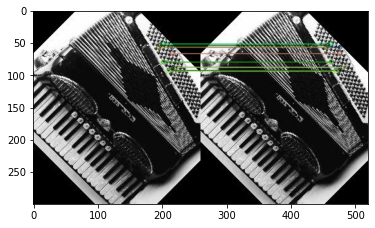

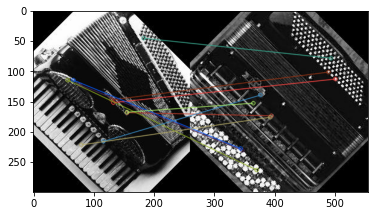

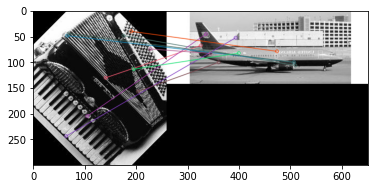

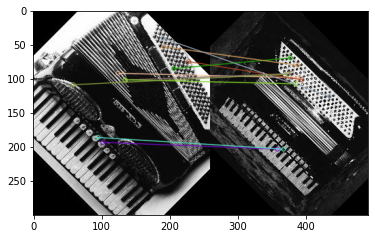

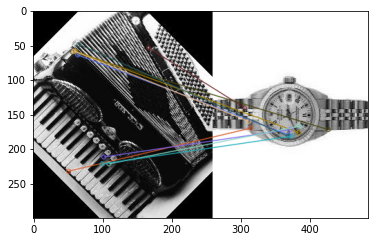

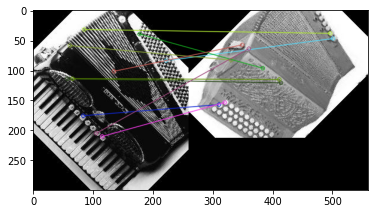

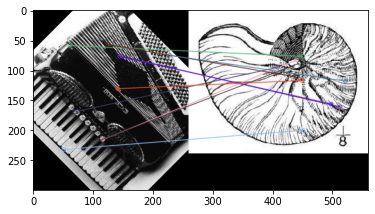

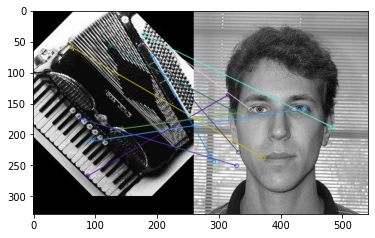

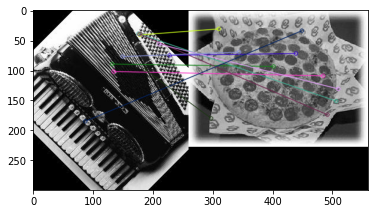

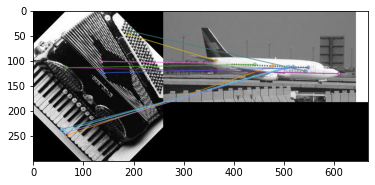

In [318]:
# TODO: find top 10 similar images for the first image of each category
# output results for the "accordion" category and calculate final accuracy
for image_path in acccord_images:
  img1 = cv.imread('/content/101_ObjectCategories/accordion/image_0001.jpg', cv.IMREAD_GRAYSCALE) 
  img2 = cv.imread('/content/101_ObjectCategories/' + image_path[0],cv.IMREAD_GRAYSCALE) # trainImage
  # Initiate ORB detector
  orb = cv.ORB_create()
  # find the keypoints and descriptors with ORB
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)
  # create BFMatcher object
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  # Match descriptors.
  matches = bf.match(des1,des2)
  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)
  # Draw first 10 matches.
  img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(img3)
  plt.show()